# Importing Lines

In [1]:
import os, sys

import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split, KFold

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('../utils/'))))
from utils.saving import *
from utils.load_data import *

# Load Data

In [2]:
CTYPE = 'multi'
loader = Loader()
X = loader.image()
y = loader.label(return_type=CTYPE)

In [ ]:
trans = transforms.Compose([transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])

In [3]:
features = ['area', 'curvature', 'jacobian_white', 'sulcus', 'thickness', 'volume']

In [4]:
channels = {feat: X[:, i, :, :].reshape(867, 1, 307, 375) for i, feat in enumerate(features)}

In [5]:
SEED = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# Build Model

In [7]:
from convnet_v3 import *

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [10]:
CTYPE = 'multi'
# model = ConvNet(ctype=CTYPE, flat_nodes=19200).to(device)
model = ConvNet(ctype=CTYPE, in_channels=1).to(device)
weight = loader.weighting(y).to(device)
loss_fn = model.loss_fn(weight=weight)

In [11]:
LEARNING_RATE = 1e-4

models = {feat: ConvNet(ctype=CTYPE, in_channels=1).to(device) for feat in features}
optims = {feat: optim.Adam(model.parameters(), lr=LEARNING_RATE) for feat, model in models.items()}

In [12]:
accuracy = model.accuracy

## Debug

In [13]:
model

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(7, 7), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [15]:
sam_dl = DataLoader(TensorDataset(channels['area'], y))
for idx, (x, y) in enumerate(sam_dl):
    if idx < 3:
        x = x.to(device)
        print(model(x))

tensor([[0.1480, 0.0628, 0.1690, 0.0999, 0.0707, 0.0812, 0.0986, 0.0523, 0.0926,
         0.1250]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[0.1459, 0.0680, 0.1708, 0.0989, 0.0700, 0.0806, 0.0968, 0.0528, 0.0930,
         0.1233]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[0.1534, 0.0686, 0.1617, 0.0990, 0.0721, 0.0804, 0.0934, 0.0551, 0.0958,
         0.1206]], device='cuda:0', grad_fn=<SoftmaxBackward>)


D:\korea_drive\brain_data\workspace\Convolution_Models\convnet_v3.py:132: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.last_layer(out)


## Train

### Holdout

In [19]:
EPOCHS = range(200)

verbose = 3

trn_losses, val_losses = dict(), dict()
trn_accs, val_accs = dict(), dict()
    
for i, feat in enumerate(features):

    print(feat)
    model = models[feat]
    optimizer = optims[feat]

    s, w, h = X_train.shape[0], *X_train.shape[2:]
    trn_dl = DataLoader(TensorDataset(X_train[:, i, :, :].reshape(s, 1, w, h), y_train), batch_size=BATCH, shuffle=True)

    s, w, h = X_test.shape[0], *X_test.shape[2:]
    tst_dl = DataLoader(TensorDataset(X_test[:, i, :, :].reshape(s, 1, w, h), y_test), batch_size=BATCH, shuffle=True)
    
    trn_losses[feat], val_losses[feat] = [], []
    trn_accs[feat], val_accs[feat] = [], []

    for epoch in EPOCHS:

        trn_bth_loss, trn_bth_acc = 0, 0
        trn_cnt = 0
        model.train()

        for x, y in trn_dl:

            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()

            y_pred = model(x).to(device)

            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()

            trn_bth_loss += loss.item()
            acc, cnt = accuracy(y_pred, y)
            trn_bth_acc += acc
            trn_cnt += cnt

        trn_losses[feat].append(trn_bth_loss / len(trn_dl))
        trn_accs[feat].append(trn_bth_acc / trn_cnt * 100)


        val_bth_loss, val_bth_acc = 0, 0
        val_cnt = 0
        model.eval()
        with torch.no_grad():
            for x, y in tst_dl:

                x, y = x.to(device), y.to(device)

                y_pred = model(x).to(device)

                loss = loss_fn(y_pred, y)

                val_bth_loss += loss.item()
                acc, cnt = accuracy(y_pred, y)
                val_bth_acc += acc
                val_cnt += cnt

            val_losses[feat].append(val_bth_loss / len(tst_dl))
            val_accs[feat].append(val_bth_acc / val_cnt * 100)

        if verbose == 0:
            if epoch % 5 == 0:
                print(f'EPOCHS {epoch} :: [LOSS] {val_losses[-1]:.3f} | [ACC] {val_accs[-1]:.3f}%')

        elif verbose == 1:
            print(f'EPOCHS {epoch} :: [LOSS] {val_losses[-1]:.3f} | [ACC] {val_accs[-1]:.3f}%')

        elif verbose == 2:
            print(f'EPOCHS {epoch}')
            print(f'TRAIN :: [LOSS] {trn_losses[-1]:.3f} | [ACC] {trn_accs[-1]:.3f}%')
            print(f'VALID :: [LOSS] {val_losses[-1]:.3f} | [ACC] {val_accs[-1]:.3f}%\n')

        elif verbose == 3:
            print(f'EPOCHS {epoch}')
            print(f'TRAIN :: [LOSS] {trn_losses[feat][-1]:.3f} | [ACC] {trn_accs[feat][-1]:.3f}%, {trn_bth_acc}/{trn_cnt}')
            print(f'VALID :: [LOSS] {val_losses[feat][-1]:.3f} | [ACC] {val_accs[feat][-1]:.3f}%, {val_bth_acc}/{val_cnt}\n')

area
EPOCHS 0
TRAIN :: [LOSS] 2.292 | [ACC] 12.266%, 85/693
VALID :: [LOSS] 2.395 | [ACC] 6.322%, 11/174

EPOCHS 1
TRAIN :: [LOSS] 2.290 | [ACC] 12.554%, 87/693
VALID :: [LOSS] 2.394 | [ACC] 6.322%, 11/174

EPOCHS 2
TRAIN :: [LOSS] 2.292 | [ACC] 13.420%, 93/693
VALID :: [LOSS] 2.396 | [ACC] 6.322%, 11/174

EPOCHS 3
TRAIN :: [LOSS] 2.293 | [ACC] 12.121%, 84/693
VALID :: [LOSS] 2.395 | [ACC] 6.322%, 11/174

EPOCHS 4
TRAIN :: [LOSS] 2.290 | [ACC] 13.420%, 93/693
VALID :: [LOSS] 2.396 | [ACC] 6.322%, 11/174

EPOCHS 5
TRAIN :: [LOSS] 2.291 | [ACC] 12.987%, 90/693
VALID :: [LOSS] 2.396 | [ACC] 6.322%, 11/174

EPOCHS 6
TRAIN :: [LOSS] 2.293 | [ACC] 12.266%, 85/693
VALID :: [LOSS] 2.396 | [ACC] 6.322%, 11/174

EPOCHS 7
TRAIN :: [LOSS] 2.292 | [ACC] 13.853%, 96/693
VALID :: [LOSS] 2.396 | [ACC] 6.322%, 11/174

EPOCHS 8
TRAIN :: [LOSS] 2.294 | [ACC] 12.266%, 85/693
VALID :: [LOSS] 2.396 | [ACC] 6.322%, 11/174

EPOCHS 9
TRAIN :: [LOSS] 2.295 | [ACC] 11.688%, 81/693
VALID :: [LOSS] 2.395 | [ACC] 6

EPOCHS 81
TRAIN :: [LOSS] 2.291 | [ACC] 12.266%, 85/693
VALID :: [LOSS] 2.395 | [ACC] 6.322%, 11/174

EPOCHS 82
TRAIN :: [LOSS] 2.290 | [ACC] 12.266%, 85/693
VALID :: [LOSS] 2.397 | [ACC] 6.322%, 11/174

EPOCHS 83
TRAIN :: [LOSS] 2.290 | [ACC] 13.420%, 93/693
VALID :: [LOSS] 2.396 | [ACC] 6.322%, 11/174

EPOCHS 84
TRAIN :: [LOSS] 2.290 | [ACC] 13.420%, 93/693
VALID :: [LOSS] 2.395 | [ACC] 6.322%, 11/174

EPOCHS 85
TRAIN :: [LOSS] 2.292 | [ACC] 13.131%, 91/693
VALID :: [LOSS] 2.396 | [ACC] 6.322%, 11/174

EPOCHS 86
TRAIN :: [LOSS] 2.290 | [ACC] 12.843%, 89/693
VALID :: [LOSS] 2.396 | [ACC] 6.322%, 11/174

EPOCHS 87
TRAIN :: [LOSS] 2.291 | [ACC] 13.564%, 94/693
VALID :: [LOSS] 2.395 | [ACC] 6.322%, 11/174

EPOCHS 88
TRAIN :: [LOSS] 2.291 | [ACC] 12.410%, 86/693
VALID :: [LOSS] 2.396 | [ACC] 6.322%, 11/174

EPOCHS 89
TRAIN :: [LOSS] 2.287 | [ACC] 13.853%, 96/693
VALID :: [LOSS] 2.396 | [ACC] 6.322%, 11/174

EPOCHS 90
TRAIN :: [LOSS] 2.290 | [ACC] 12.843%, 89/693
VALID :: [LOSS] 2.396 | [A

EPOCHS 161
TRAIN :: [LOSS] 2.287 | [ACC] 13.997%, 97/693
VALID :: [LOSS] 2.394 | [ACC] 6.322%, 11/174

EPOCHS 162
TRAIN :: [LOSS] 2.288 | [ACC] 13.853%, 96/693
VALID :: [LOSS] 2.396 | [ACC] 6.322%, 11/174

EPOCHS 163
TRAIN :: [LOSS] 2.294 | [ACC] 11.111%, 77/693
VALID :: [LOSS] 2.396 | [ACC] 6.322%, 11/174

EPOCHS 164
TRAIN :: [LOSS] 2.283 | [ACC] 13.709%, 95/693
VALID :: [LOSS] 2.396 | [ACC] 6.322%, 11/174

EPOCHS 165
TRAIN :: [LOSS] 2.289 | [ACC] 14.430%, 100/693
VALID :: [LOSS] 2.396 | [ACC] 6.322%, 11/174

EPOCHS 166
TRAIN :: [LOSS] 2.291 | [ACC] 13.131%, 91/693
VALID :: [LOSS] 2.395 | [ACC] 6.322%, 11/174

EPOCHS 167
TRAIN :: [LOSS] 2.289 | [ACC] 14.286%, 99/693
VALID :: [LOSS] 2.393 | [ACC] 6.322%, 11/174

EPOCHS 168
TRAIN :: [LOSS] 2.288 | [ACC] 13.709%, 95/693
VALID :: [LOSS] 2.394 | [ACC] 6.322%, 11/174

EPOCHS 169
TRAIN :: [LOSS] 2.288 | [ACC] 14.286%, 99/693
VALID :: [LOSS] 2.396 | [ACC] 6.322%, 11/174

EPOCHS 170
TRAIN :: [LOSS] 2.287 | [ACC] 14.719%, 102/693
VALID :: [LOSS

EPOCHS 41
TRAIN :: [LOSS] 2.303 | [ACC] 10.534%, 73/693
VALID :: [LOSS] 2.307 | [ACC] 6.322%, 11/174

EPOCHS 42
TRAIN :: [LOSS] 2.302 | [ACC] 10.534%, 73/693
VALID :: [LOSS] 2.308 | [ACC] 6.322%, 11/174

EPOCHS 43
TRAIN :: [LOSS] 2.303 | [ACC] 8.947%, 62/693
VALID :: [LOSS] 2.308 | [ACC] 6.322%, 11/174

EPOCHS 44
TRAIN :: [LOSS] 2.303 | [ACC] 13.131%, 91/693
VALID :: [LOSS] 2.308 | [ACC] 6.322%, 11/174

EPOCHS 45
TRAIN :: [LOSS] 2.303 | [ACC] 9.235%, 64/693
VALID :: [LOSS] 2.308 | [ACC] 6.322%, 11/174

EPOCHS 46
TRAIN :: [LOSS] 2.303 | [ACC] 10.390%, 72/693
VALID :: [LOSS] 2.308 | [ACC] 6.322%, 11/174

EPOCHS 47
TRAIN :: [LOSS] 2.302 | [ACC] 9.235%, 64/693
VALID :: [LOSS] 2.308 | [ACC] 10.345%, 18/174

EPOCHS 48
TRAIN :: [LOSS] 2.302 | [ACC] 10.967%, 76/693
VALID :: [LOSS] 2.308 | [ACC] 6.322%, 11/174

EPOCHS 49
TRAIN :: [LOSS] 2.302 | [ACC] 9.812%, 68/693
VALID :: [LOSS] 2.308 | [ACC] 6.322%, 11/174

EPOCHS 50
TRAIN :: [LOSS] 2.302 | [ACC] 9.812%, 68/693
VALID :: [LOSS] 2.308 | [ACC] 

EPOCHS 122
TRAIN :: [LOSS] 2.302 | [ACC] 10.390%, 72/693
VALID :: [LOSS] 2.310 | [ACC] 6.322%, 11/174

EPOCHS 123
TRAIN :: [LOSS] 2.302 | [ACC] 10.390%, 72/693
VALID :: [LOSS] 2.309 | [ACC] 6.322%, 11/174

EPOCHS 124
TRAIN :: [LOSS] 2.301 | [ACC] 10.390%, 72/693
VALID :: [LOSS] 2.309 | [ACC] 6.322%, 11/174

EPOCHS 125
TRAIN :: [LOSS] 2.301 | [ACC] 10.390%, 72/693
VALID :: [LOSS] 2.310 | [ACC] 6.322%, 11/174

EPOCHS 126
TRAIN :: [LOSS] 2.302 | [ACC] 10.390%, 72/693
VALID :: [LOSS] 2.310 | [ACC] 6.322%, 11/174

EPOCHS 127
TRAIN :: [LOSS] 2.301 | [ACC] 10.390%, 72/693
VALID :: [LOSS] 2.310 | [ACC] 6.322%, 11/174

EPOCHS 128
TRAIN :: [LOSS] 2.303 | [ACC] 10.390%, 72/693
VALID :: [LOSS] 2.310 | [ACC] 6.322%, 11/174

EPOCHS 129
TRAIN :: [LOSS] 2.302 | [ACC] 10.390%, 72/693
VALID :: [LOSS] 2.310 | [ACC] 6.322%, 11/174

EPOCHS 130
TRAIN :: [LOSS] 2.302 | [ACC] 10.390%, 72/693
VALID :: [LOSS] 2.310 | [ACC] 6.322%, 11/174

EPOCHS 131
TRAIN :: [LOSS] 2.302 | [ACC] 8.947%, 62/693
VALID :: [LOSS] 2

EPOCHS 2
TRAIN :: [LOSS] 2.305 | [ACC] 9.091%, 63/693
VALID :: [LOSS] 2.306 | [ACC] 5.747%, 10/174

EPOCHS 3
TRAIN :: [LOSS] 2.304 | [ACC] 10.390%, 72/693
VALID :: [LOSS] 2.305 | [ACC] 7.471%, 13/174

EPOCHS 4
TRAIN :: [LOSS] 2.304 | [ACC] 10.101%, 70/693
VALID :: [LOSS] 2.306 | [ACC] 10.345%, 18/174

EPOCHS 5
TRAIN :: [LOSS] 2.304 | [ACC] 9.668%, 67/693
VALID :: [LOSS] 2.306 | [ACC] 10.345%, 18/174

EPOCHS 6
TRAIN :: [LOSS] 2.303 | [ACC] 9.957%, 69/693
VALID :: [LOSS] 2.306 | [ACC] 6.322%, 11/174

EPOCHS 7
TRAIN :: [LOSS] 2.303 | [ACC] 10.390%, 72/693
VALID :: [LOSS] 2.307 | [ACC] 10.345%, 18/174

EPOCHS 8
TRAIN :: [LOSS] 2.304 | [ACC] 8.369%, 58/693
VALID :: [LOSS] 2.307 | [ACC] 10.345%, 18/174

EPOCHS 9
TRAIN :: [LOSS] 2.304 | [ACC] 9.812%, 68/693
VALID :: [LOSS] 2.307 | [ACC] 10.345%, 18/174

EPOCHS 10
TRAIN :: [LOSS] 2.303 | [ACC] 9.957%, 69/693
VALID :: [LOSS] 2.306 | [ACC] 10.345%, 18/174

EPOCHS 11
TRAIN :: [LOSS] 2.303 | [ACC] 9.235%, 64/693
VALID :: [LOSS] 2.307 | [ACC] 10.34

EPOCHS 83
TRAIN :: [LOSS] 2.303 | [ACC] 7.504%, 52/693
VALID :: [LOSS] 2.309 | [ACC] 7.471%, 13/174

EPOCHS 84
TRAIN :: [LOSS] 2.301 | [ACC] 9.957%, 69/693
VALID :: [LOSS] 2.309 | [ACC] 11.494%, 20/174

EPOCHS 85
TRAIN :: [LOSS] 2.302 | [ACC] 10.390%, 72/693
VALID :: [LOSS] 2.309 | [ACC] 6.322%, 11/174

EPOCHS 86
TRAIN :: [LOSS] 2.303 | [ACC] 9.235%, 64/693
VALID :: [LOSS] 2.309 | [ACC] 6.322%, 11/174

EPOCHS 87
TRAIN :: [LOSS] 2.302 | [ACC] 10.390%, 72/693
VALID :: [LOSS] 2.308 | [ACC] 10.345%, 18/174

EPOCHS 88
TRAIN :: [LOSS] 2.301 | [ACC] 10.390%, 72/693
VALID :: [LOSS] 2.309 | [ACC] 10.345%, 18/174

EPOCHS 89
TRAIN :: [LOSS] 2.302 | [ACC] 10.101%, 70/693
VALID :: [LOSS] 2.309 | [ACC] 6.322%, 11/174

EPOCHS 90
TRAIN :: [LOSS] 2.301 | [ACC] 9.380%, 65/693
VALID :: [LOSS] 2.309 | [ACC] 10.345%, 18/174

EPOCHS 91
TRAIN :: [LOSS] 2.302 | [ACC] 9.957%, 69/693
VALID :: [LOSS] 2.310 | [ACC] 6.322%, 11/174

EPOCHS 92
TRAIN :: [LOSS] 2.302 | [ACC] 10.390%, 72/693
VALID :: [LOSS] 2.309 | [AC

EPOCHS 163
TRAIN :: [LOSS] 2.303 | [ACC] 10.390%, 72/693
VALID :: [LOSS] 2.310 | [ACC] 7.471%, 13/174

EPOCHS 164
TRAIN :: [LOSS] 2.302 | [ACC] 10.390%, 72/693
VALID :: [LOSS] 2.309 | [ACC] 6.322%, 11/174

EPOCHS 165
TRAIN :: [LOSS] 2.302 | [ACC] 9.812%, 68/693
VALID :: [LOSS] 2.310 | [ACC] 6.322%, 11/174

EPOCHS 166
TRAIN :: [LOSS] 2.302 | [ACC] 10.101%, 70/693
VALID :: [LOSS] 2.310 | [ACC] 6.897%, 12/174

EPOCHS 167
TRAIN :: [LOSS] 2.302 | [ACC] 10.390%, 72/693
VALID :: [LOSS] 2.310 | [ACC] 6.322%, 11/174

EPOCHS 168
TRAIN :: [LOSS] 2.301 | [ACC] 10.390%, 72/693
VALID :: [LOSS] 2.310 | [ACC] 6.322%, 11/174

EPOCHS 169
TRAIN :: [LOSS] 2.302 | [ACC] 10.390%, 72/693
VALID :: [LOSS] 2.310 | [ACC] 6.322%, 11/174

EPOCHS 170
TRAIN :: [LOSS] 2.301 | [ACC] 10.390%, 72/693
VALID :: [LOSS] 2.309 | [ACC] 6.322%, 11/174

EPOCHS 171
TRAIN :: [LOSS] 2.301 | [ACC] 10.390%, 72/693
VALID :: [LOSS] 2.310 | [ACC] 6.322%, 11/174

EPOCHS 172
TRAIN :: [LOSS] 2.301 | [ACC] 10.101%, 70/693
VALID :: [LOSS] 2

EPOCHS 44
TRAIN :: [LOSS] 2.302 | [ACC] 10.390%, 72/693
VALID :: [LOSS] 2.312 | [ACC] 6.322%, 11/174

EPOCHS 45
TRAIN :: [LOSS] 2.303 | [ACC] 10.390%, 72/693
VALID :: [LOSS] 2.311 | [ACC] 10.345%, 18/174

EPOCHS 46
TRAIN :: [LOSS] 2.302 | [ACC] 9.235%, 64/693
VALID :: [LOSS] 2.310 | [ACC] 10.345%, 18/174

EPOCHS 47
TRAIN :: [LOSS] 2.303 | [ACC] 8.658%, 60/693
VALID :: [LOSS] 2.311 | [ACC] 5.747%, 10/174

EPOCHS 48
TRAIN :: [LOSS] 2.302 | [ACC] 11.833%, 82/693
VALID :: [LOSS] 2.311 | [ACC] 5.747%, 10/174

EPOCHS 49
TRAIN :: [LOSS] 2.303 | [ACC] 11.255%, 78/693
VALID :: [LOSS] 2.312 | [ACC] 6.322%, 11/174

EPOCHS 50
TRAIN :: [LOSS] 2.302 | [ACC] 10.390%, 72/693
VALID :: [LOSS] 2.311 | [ACC] 6.322%, 11/174

EPOCHS 51
TRAIN :: [LOSS] 2.302 | [ACC] 11.977%, 83/693
VALID :: [LOSS] 2.311 | [ACC] 10.345%, 18/174

EPOCHS 52
TRAIN :: [LOSS] 2.301 | [ACC] 11.255%, 78/693
VALID :: [LOSS] 2.313 | [ACC] 6.322%, 11/174

EPOCHS 53
TRAIN :: [LOSS] 2.303 | [ACC] 10.678%, 74/693
VALID :: [LOSS] 2.312 | [

EPOCHS 124
TRAIN :: [LOSS] 2.243 | [ACC] 20.779%, 144/693
VALID :: [LOSS] 2.395 | [ACC] 6.322%, 11/174

EPOCHS 125
TRAIN :: [LOSS] 2.253 | [ACC] 20.491%, 142/693
VALID :: [LOSS] 2.375 | [ACC] 6.897%, 12/174

EPOCHS 126
TRAIN :: [LOSS] 2.253 | [ACC] 20.346%, 141/693
VALID :: [LOSS] 2.395 | [ACC] 6.322%, 11/174

EPOCHS 127
TRAIN :: [LOSS] 2.242 | [ACC] 22.367%, 155/693
VALID :: [LOSS] 2.322 | [ACC] 12.069%, 21/174

EPOCHS 128
TRAIN :: [LOSS] 2.241 | [ACC] 22.078%, 153/693
VALID :: [LOSS] 2.319 | [ACC] 12.644%, 22/174

EPOCHS 129
TRAIN :: [LOSS] 2.242 | [ACC] 19.625%, 136/693
VALID :: [LOSS] 2.348 | [ACC] 8.046%, 14/174

EPOCHS 130
TRAIN :: [LOSS] 2.251 | [ACC] 19.769%, 137/693
VALID :: [LOSS] 2.378 | [ACC] 6.322%, 11/174

EPOCHS 131
TRAIN :: [LOSS] 2.241 | [ACC] 21.068%, 146/693
VALID :: [LOSS] 2.343 | [ACC] 8.621%, 15/174

EPOCHS 132
TRAIN :: [LOSS] 2.244 | [ACC] 20.491%, 142/693
VALID :: [LOSS] 2.317 | [ACC] 12.644%, 22/174

EPOCHS 133
TRAIN :: [LOSS] 2.254 | [ACC] 18.182%, 126/693
VAL

EPOCHS 3
TRAIN :: [LOSS] 2.304 | [ACC] 11.833%, 82/693
VALID :: [LOSS] 2.306 | [ACC] 10.345%, 18/174

EPOCHS 4
TRAIN :: [LOSS] 2.303 | [ACC] 12.121%, 84/693
VALID :: [LOSS] 2.306 | [ACC] 8.046%, 14/174

EPOCHS 5
TRAIN :: [LOSS] 2.303 | [ACC] 9.380%, 65/693
VALID :: [LOSS] 2.306 | [ACC] 9.195%, 16/174

EPOCHS 6
TRAIN :: [LOSS] 2.304 | [ACC] 7.215%, 50/693
VALID :: [LOSS] 2.307 | [ACC] 6.322%, 11/174

EPOCHS 7
TRAIN :: [LOSS] 2.304 | [ACC] 10.390%, 72/693
VALID :: [LOSS] 2.306 | [ACC] 10.345%, 18/174

EPOCHS 8
TRAIN :: [LOSS] 2.306 | [ACC] 10.390%, 72/693
VALID :: [LOSS] 2.306 | [ACC] 10.345%, 18/174

EPOCHS 9
TRAIN :: [LOSS] 2.304 | [ACC] 12.843%, 89/693
VALID :: [LOSS] 2.306 | [ACC] 9.770%, 17/174

EPOCHS 10
TRAIN :: [LOSS] 2.304 | [ACC] 8.514%, 59/693
VALID :: [LOSS] 2.307 | [ACC] 9.195%, 16/174

EPOCHS 11
TRAIN :: [LOSS] 2.304 | [ACC] 9.380%, 65/693
VALID :: [LOSS] 2.306 | [ACC] 9.195%, 16/174

EPOCHS 12
TRAIN :: [LOSS] 2.303 | [ACC] 11.833%, 82/693
VALID :: [LOSS] 2.307 | [ACC] 10.3

EPOCHS 84
TRAIN :: [LOSS] 2.302 | [ACC] 8.947%, 62/693
VALID :: [LOSS] 2.317 | [ACC] 9.770%, 17/174

EPOCHS 85
TRAIN :: [LOSS] 2.303 | [ACC] 9.091%, 63/693
VALID :: [LOSS] 2.320 | [ACC] 9.770%, 17/174

EPOCHS 86
TRAIN :: [LOSS] 2.303 | [ACC] 9.957%, 69/693
VALID :: [LOSS] 2.320 | [ACC] 9.770%, 17/174

EPOCHS 87
TRAIN :: [LOSS] 2.302 | [ACC] 12.987%, 90/693
VALID :: [LOSS] 2.322 | [ACC] 9.770%, 17/174

EPOCHS 88
TRAIN :: [LOSS] 2.303 | [ACC] 9.235%, 64/693
VALID :: [LOSS] 2.322 | [ACC] 9.770%, 17/174

EPOCHS 89
TRAIN :: [LOSS] 2.301 | [ACC] 8.658%, 60/693
VALID :: [LOSS] 2.326 | [ACC] 9.770%, 17/174

EPOCHS 90
TRAIN :: [LOSS] 2.302 | [ACC] 9.957%, 69/693
VALID :: [LOSS] 2.331 | [ACC] 9.770%, 17/174

EPOCHS 91
TRAIN :: [LOSS] 2.300 | [ACC] 10.534%, 73/693
VALID :: [LOSS] 2.344 | [ACC] 9.770%, 17/174

EPOCHS 92
TRAIN :: [LOSS] 2.301 | [ACC] 11.111%, 77/693
VALID :: [LOSS] 2.323 | [ACC] 9.770%, 17/174

EPOCHS 93
TRAIN :: [LOSS] 2.302 | [ACC] 10.101%, 70/693
VALID :: [LOSS] 2.318 | [ACC] 9.

EPOCHS 164
TRAIN :: [LOSS] 2.294 | [ACC] 13.131%, 91/693
VALID :: [LOSS] 2.357 | [ACC] 9.770%, 17/174

EPOCHS 165
TRAIN :: [LOSS] 2.295 | [ACC] 12.121%, 84/693
VALID :: [LOSS] 2.359 | [ACC] 9.770%, 17/174

EPOCHS 166
TRAIN :: [LOSS] 2.296 | [ACC] 12.698%, 88/693
VALID :: [LOSS] 2.356 | [ACC] 9.770%, 17/174

EPOCHS 167
TRAIN :: [LOSS] 2.295 | [ACC] 13.131%, 91/693
VALID :: [LOSS] 2.346 | [ACC] 9.770%, 17/174

EPOCHS 168
TRAIN :: [LOSS] 2.295 | [ACC] 12.554%, 87/693
VALID :: [LOSS] 2.346 | [ACC] 9.770%, 17/174

EPOCHS 169
TRAIN :: [LOSS] 2.293 | [ACC] 12.554%, 87/693
VALID :: [LOSS] 2.354 | [ACC] 9.770%, 17/174

EPOCHS 170
TRAIN :: [LOSS] 2.295 | [ACC] 11.688%, 81/693
VALID :: [LOSS] 2.360 | [ACC] 9.770%, 17/174

EPOCHS 171
TRAIN :: [LOSS] 2.296 | [ACC] 11.111%, 77/693
VALID :: [LOSS] 2.359 | [ACC] 9.770%, 17/174

EPOCHS 172
TRAIN :: [LOSS] 2.295 | [ACC] 11.544%, 80/693
VALID :: [LOSS] 2.360 | [ACC] 9.770%, 17/174

EPOCHS 173
TRAIN :: [LOSS] 2.293 | [ACC] 12.987%, 90/693
VALID :: [LOSS] 

EPOCHS 45
TRAIN :: [LOSS] 2.297 | [ACC] 11.688%, 81/693
VALID :: [LOSS] 2.346 | [ACC] 6.322%, 11/174

EPOCHS 46
TRAIN :: [LOSS] 2.299 | [ACC] 10.101%, 70/693
VALID :: [LOSS] 2.335 | [ACC] 6.322%, 11/174

EPOCHS 47
TRAIN :: [LOSS] 2.295 | [ACC] 11.544%, 80/693
VALID :: [LOSS] 2.360 | [ACC] 6.322%, 11/174

EPOCHS 48
TRAIN :: [LOSS] 2.291 | [ACC] 11.977%, 83/693
VALID :: [LOSS] 2.347 | [ACC] 6.322%, 11/174

EPOCHS 49
TRAIN :: [LOSS] 2.297 | [ACC] 12.121%, 84/693
VALID :: [LOSS] 2.355 | [ACC] 6.322%, 11/174

EPOCHS 50
TRAIN :: [LOSS] 2.294 | [ACC] 13.997%, 97/693
VALID :: [LOSS] 2.364 | [ACC] 6.322%, 11/174

EPOCHS 51
TRAIN :: [LOSS] 2.292 | [ACC] 11.544%, 80/693
VALID :: [LOSS] 2.347 | [ACC] 6.322%, 11/174

EPOCHS 52
TRAIN :: [LOSS] 2.294 | [ACC] 11.977%, 83/693
VALID :: [LOSS] 2.359 | [ACC] 6.322%, 11/174

EPOCHS 53
TRAIN :: [LOSS] 2.296 | [ACC] 10.967%, 76/693
VALID :: [LOSS] 2.351 | [ACC] 6.322%, 11/174

EPOCHS 54
TRAIN :: [LOSS] 2.294 | [ACC] 12.266%, 85/693
VALID :: [LOSS] 2.381 | [A

EPOCHS 125
TRAIN :: [LOSS] 2.278 | [ACC] 15.296%, 106/693
VALID :: [LOSS] 2.384 | [ACC] 6.322%, 11/174

EPOCHS 126
TRAIN :: [LOSS] 2.273 | [ACC] 16.450%, 114/693
VALID :: [LOSS] 2.371 | [ACC] 6.322%, 11/174

EPOCHS 127
TRAIN :: [LOSS] 2.278 | [ACC] 15.873%, 110/693
VALID :: [LOSS] 2.361 | [ACC] 5.747%, 10/174

EPOCHS 128
TRAIN :: [LOSS] 2.280 | [ACC] 15.584%, 108/693
VALID :: [LOSS] 2.384 | [ACC] 6.322%, 11/174

EPOCHS 129
TRAIN :: [LOSS] 2.276 | [ACC] 15.584%, 108/693
VALID :: [LOSS] 2.386 | [ACC] 6.322%, 11/174

EPOCHS 130
TRAIN :: [LOSS] 2.280 | [ACC] 16.162%, 112/693
VALID :: [LOSS] 2.357 | [ACC] 5.747%, 10/174

EPOCHS 131
TRAIN :: [LOSS] 2.276 | [ACC] 15.584%, 108/693
VALID :: [LOSS] 2.383 | [ACC] 6.322%, 11/174

EPOCHS 132
TRAIN :: [LOSS] 2.270 | [ACC] 17.172%, 119/693
VALID :: [LOSS] 2.375 | [ACC] 6.322%, 11/174

EPOCHS 133
TRAIN :: [LOSS] 2.274 | [ACC] 15.873%, 110/693
VALID :: [LOSS] 2.360 | [ACC] 5.747%, 10/174

EPOCHS 134
TRAIN :: [LOSS] 2.273 | [ACC] 15.584%, 108/693
VALID 

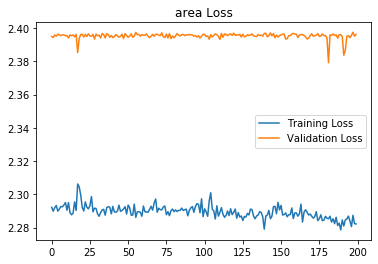

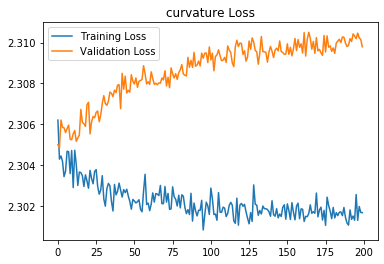

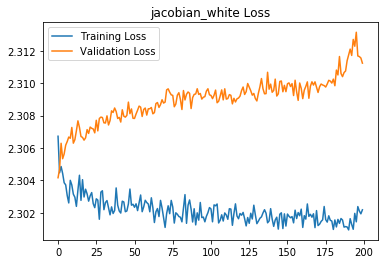

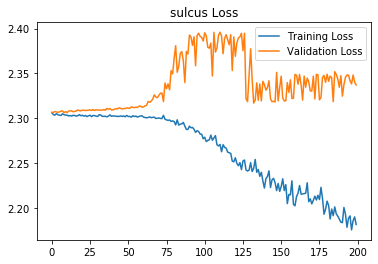

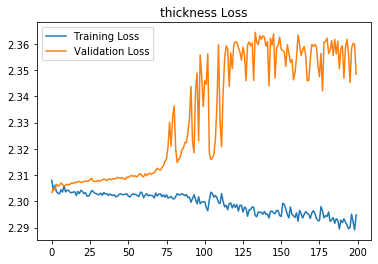

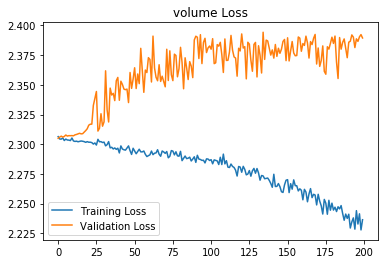

In [32]:
for feat, (trn, val) in zip(features, zip(trn_losses.values(), val_losses.values())):
        
    plt.title(f'{feat} Loss')
    plt.plot(trn, label='Training Loss')
    plt.plot(val, label='Validation Loss')
    plt.legend()
    plt.plot()
    plt.savefig(f'{feat}_loss.jpg')
    plt.show()
    plt.close()

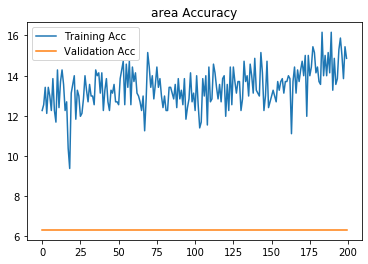

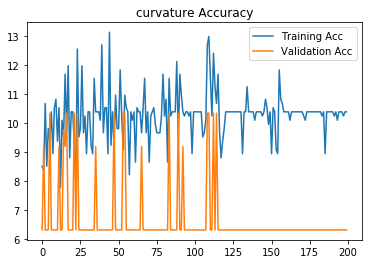

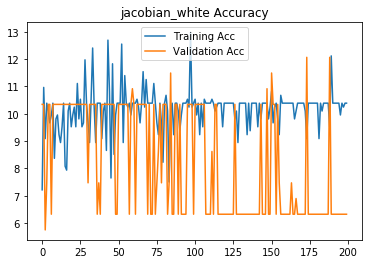

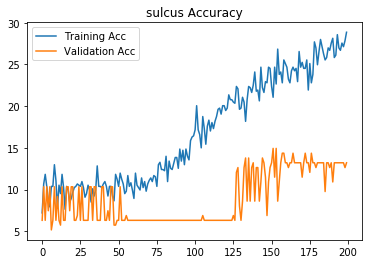

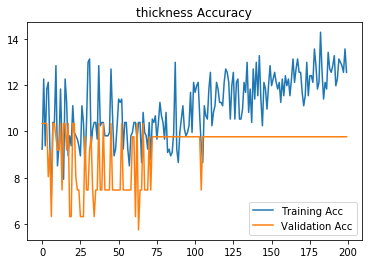

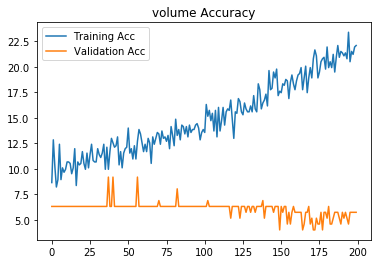

In [33]:
for feat, (trn, val) in zip(features, zip(trn_accs.values(), val_accs.values())):
        
    plt.title(f'{feat} Accuracy')
    plt.plot(trn, label='Training Acc')
    plt.plot(val, label='Validation Acc')
    plt.legend()
    plt.plot()
    plt.savefig(f'{feat}_acc.jpg')
    plt.show()
    plt.close()

In [22]:
comments = f'BATCH: {BATCH} | LR: {LEARNING_RATE} | EPOCHS: {EPOCHS}'
save_model(model, EPOCHS, optimizer, loss_fn, [trn_losses, val_losses, trn_accs, val_accs], comments)

### K-Folds

In [ ]:
EPOCHS = range(200)
FOLDS = 10

SPLITS = 10

cv_loss_trn, cv_loss_val = [], []
cv_accs_trn, cv_accs_val = [], []

verbose = 3

kfold = KFold(n_splits=SPLITS)
for i, (trn_idx, val_idx) in enumerate(kfold.split(X_train)):
    print(f'FOLD :: {i}')
    
    trn_fdl = DataLoader(TensorDataset(X_train[trn_idx], y_train[trn_idx]))
    val_fdl = DataLoader(TensorDataset(X_train[val_idx], y_train[val_idx]))
    
    trn_losses, val_losses = [], []
    trn_accs, val_accs = [], []
    
    for epoch in EPOCHS:
        
        trn_bth_loss, trn_bth_acc = 0, 0
        trn_cnt = 0
        model.train()
        for x, y in trn_fdl:
            
            optimizer.zero_grad()
            
            y_pred = model(x)
            
            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()
            
            trn_bth_loss += loss.item()
            acc, cnt = accuracy(y_pred, y)
            trn_bth_acc += acc
            trn_cnt += cnt
            
        #trn_cnt = trn_fdl.__len__()
        trn_losses.append(trn_bth_loss / trn_cnt)
        trn_accs.append(trn_bth_acc / trn_cnt * 100)
        
        
        val_bth_loss, val_bth_acc = 0, 0
        val_cnt = 0
        model.eval()
        with torch.no_grad():
            for x, y in val_fdl:

                y_pred = model(x)

                loss = loss_fn(y_pred, y)

                val_bth_loss += loss.item()
                acc, cnt = accuracy(y_pred, y)
                val_bth_acc += acc
                val_cnt += cnt

            #val_cnt = val_fdl.__len__()
            val_losses.append(val_bth_loss / val_cnt)
            val_accs.append(val_bth_acc / val_cnt * 100)
        
        if verbose == 0:
            if epoch % 5 == 0:
                print(f'EPOCHS {epoch} :: [LOSS] {val_losses[-1]:.3f} | [ACC] {val_accs[-1]:.3f}%')
                
        elif verbose == 1:
            print(f'EPOCHS {epoch} :: [LOSS] {val_losses[-1]:.3f} | [ACC] {val_accs[-1]:.3f}%')
            
        elif verbose == 2:
            print(f'EPOCHS {epoch}')
            print(f'TRAIN :: [LOSS] {trn_losses[-1]:.3f} | [ACC] {trn_accs[-1]:.3f}%')
            print(f'VALID :: [LOSS] {val_losses[-1]:.3f} | [ACC] {val_accs[-1]:.3f}%\n')
            
        elif verbose == 3:
            print(f'EPOCHS {epoch}')
            print(f'TRAIN :: [LOSS] {trn_losses[-1]:.3f} | [ACC] {trn_accs[-1]:.3f}%, {trn_bth_acc}/{trn_cnt}')
            print(f'VALID :: [LOSS] {val_losses[-1]:.3f} | [ACC] {val_accs[-1]:.3f}%, {val_bth_acc}/{val_cnt}\n')
            
    cv_loss_trn.append(trn_losses)
    cv_accs_trn.append(trn_accs)
    
    cv_loss_val.append(val_losses)
    cv_accs_val.append(val_accs)

FOLD :: 0


In [ ]:
from utils.plotting_utils import *

cv_plotter(cv_loss_trn, cv_loss_val, title='loss')

In [ ]:
cv_plotter(cv_accs_trn, cv_accs_val, title='acc')

## With Hold-out Testset

In [ ]:
with torch.no_grad():
    
    tst_loss, tst_acc = 0, 0
    tst_cnt = 0
    model.eval()
    for x, y in tst_dl:
        
        y_pred = model(x)
        
        loss = loss_fn(y_pred, y)
        
        tst_loss += loss.item()
        acc, cnt = accuracy(y_pred, y)
        tst_acc += acc
        tst_cnt += cnt
    
    #tst_acc /= tst_cnt
print(f'HOLDOUT TESTSET :: [LOSS] {tst_loss:.3f} | [ACC] {tst_acc/tst_cnt * 100:.3f}% {tst_acc}/{tst_cnt}')

In [ ]:
y_pred.argmax(axis=1), y

## Save Model

In [44]:
import time
t = time.gmtime(time.time())

SAVE_PATH = f'./models/{t.tm_year}_{t.tm_mon}_{t.tm_mday}-{t.tm_hour}_{t.tm_min}.pt'
torch.save({
            'epoch': EPOCHS,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_fn,
            }, SAVE_PATH)

In [ ]:
loading = ConvNet(CTYPE)

In [ ]:
ckpnt = torch.load(SAVE_PATH)

In [ ]:
model.load_state_dict(ckpnt['model_state_dict'])

In [ ]:
model